# If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Reading dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/ml/nutrition.csv

In [3]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

print("HELLO", dataset['Food Type'][0])
classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

HELLO 0
Names: | Asparagus, 5 spears (93 g/3.3 oz) | Bell Pepper, 1 medium (148 g/5.3 oz) | Broccoli, 1 medium stalk (148 g/5.3 oz) | Carrot, 1 carrot, 7" long, 1 1/4" diameter (78 g/2.8 oz) | Cauliflower, 1/6 medium head (99 g/3.5 oz) | ...

Classes: | Seafood, Serving Size (84 g/3 oz) | Vegetables, Serving Size (gram weight/ ounce weight) | Fruits Serving Size (gram weight/ounce weight)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [4]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Seafood, Serving Size (84 g/3 oz)': 'red', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'green', 'Fruits Serving Size (gram weight/ounce weight)': 'blue'}


## Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [5]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## Data Visualization
`A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 fearures). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


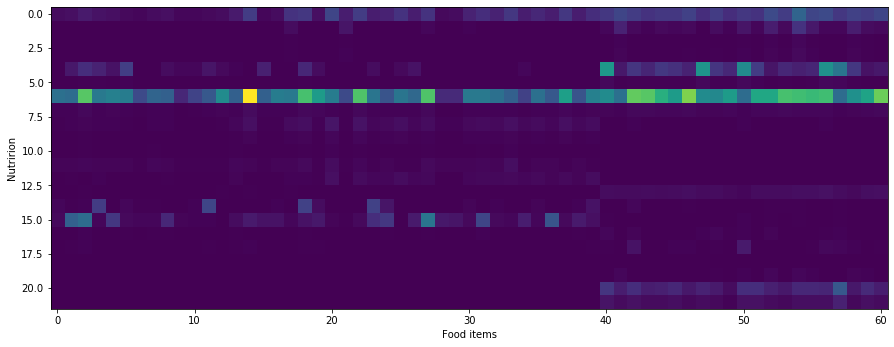

2 random dimensions distribution


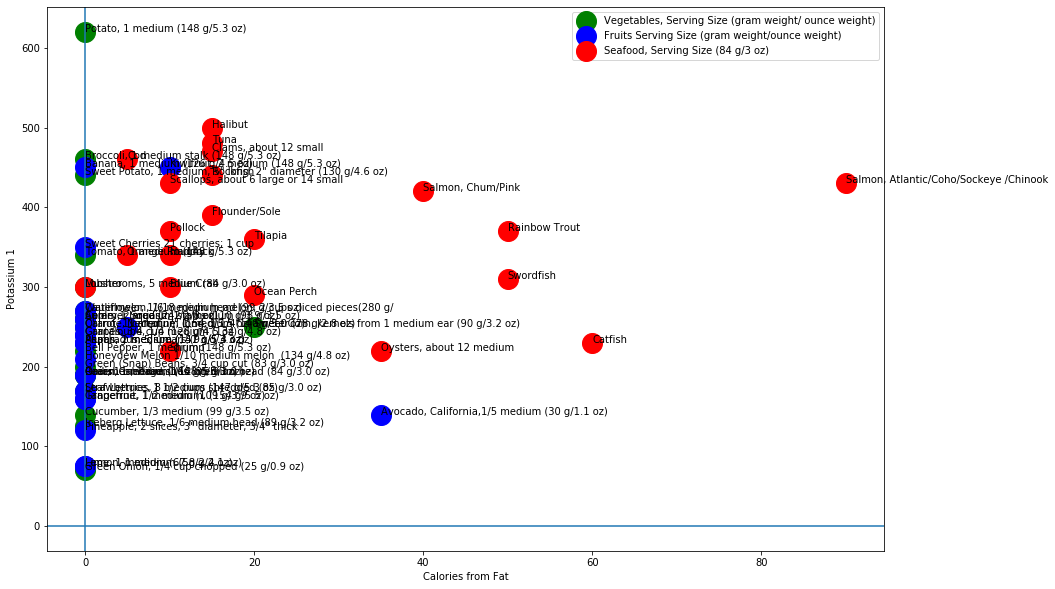

In [6]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutririon")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express the difference in the dataset in the best way. The variance is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. Fill in the code to apply PCA to our data.

In [7]:
from sklearn.decomposition import PCA

#TODO apply PCA to matrix A, and save the results to Ak
k = 3
pca = PCA(n_components=k)
pca.fit(A)
Ak = pca.transform(A)
Ak.shape

(61, 3)

Check how much variance is explained by the first components

In [8]:
#TODO check variance
print(pca.explained_variance_ratio_)

[0.56816006 0.24450404 0.09653148]


Now let's visualize the data after transformation applied

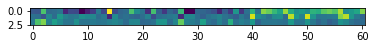

2 first dimensions


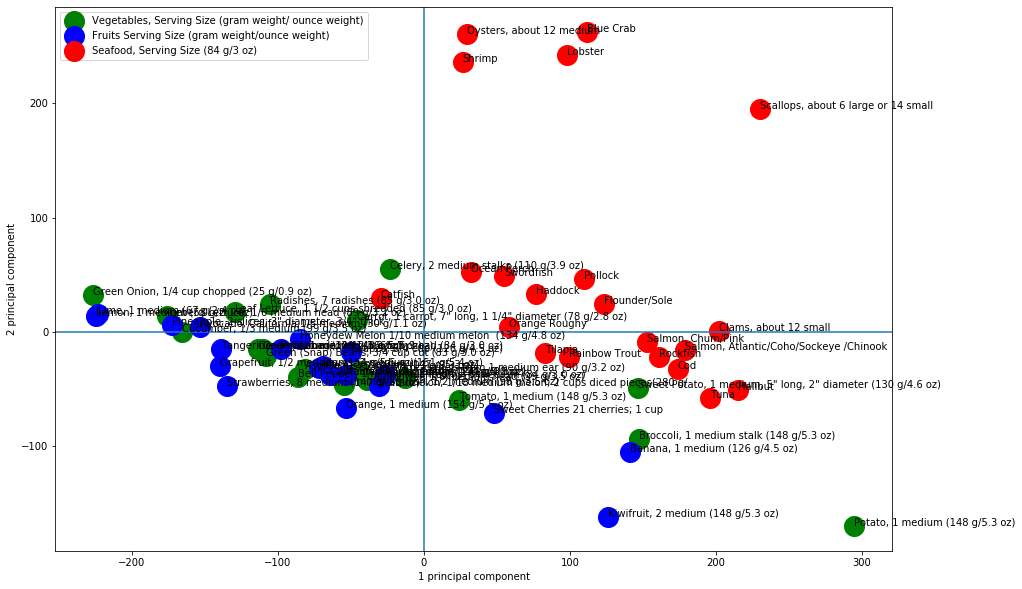

3 first dimensions


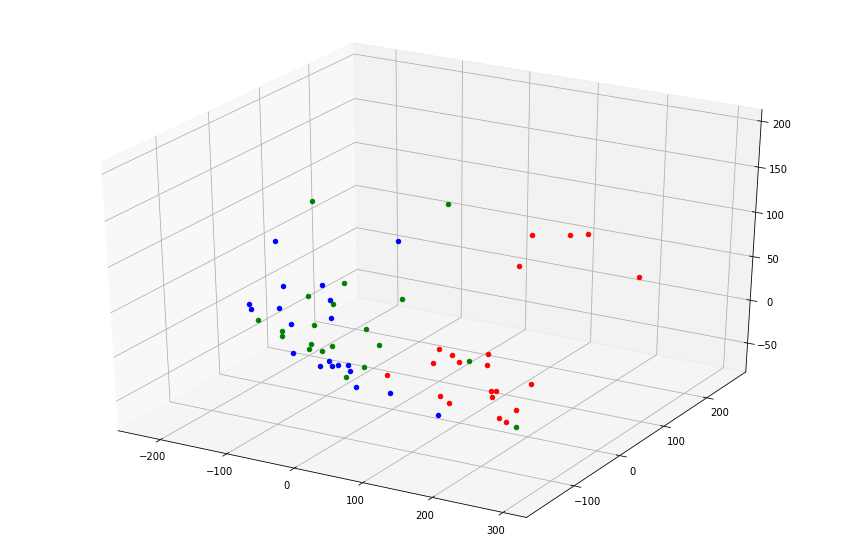

In [9]:
plt.imshow(Ak.T)
plt.show()

print("2 first dimensions")
show_points_2d(Ak.T[0], Ak.T[1], "1 principal component", "2 principal component")
print("3 first dimensions")
show_points_3d(Ak.T[0], Ak.T[1], Ak.T[2])

## Norming
It can happen, that some food is more "condenced" than the others. See, how different celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ norm to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same". Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

2 first dimensions


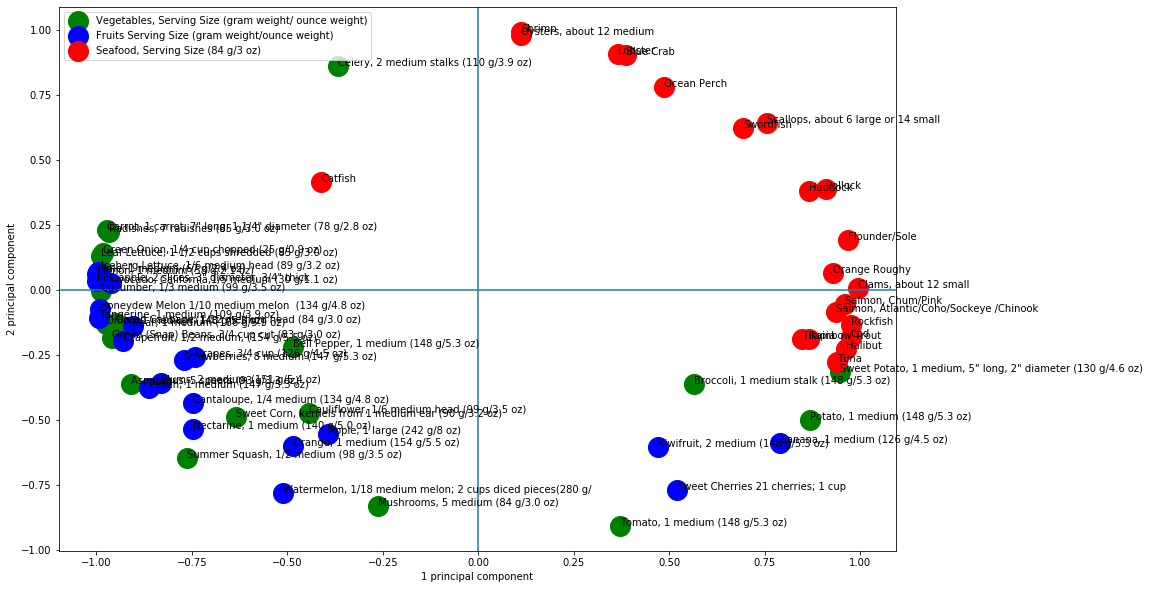

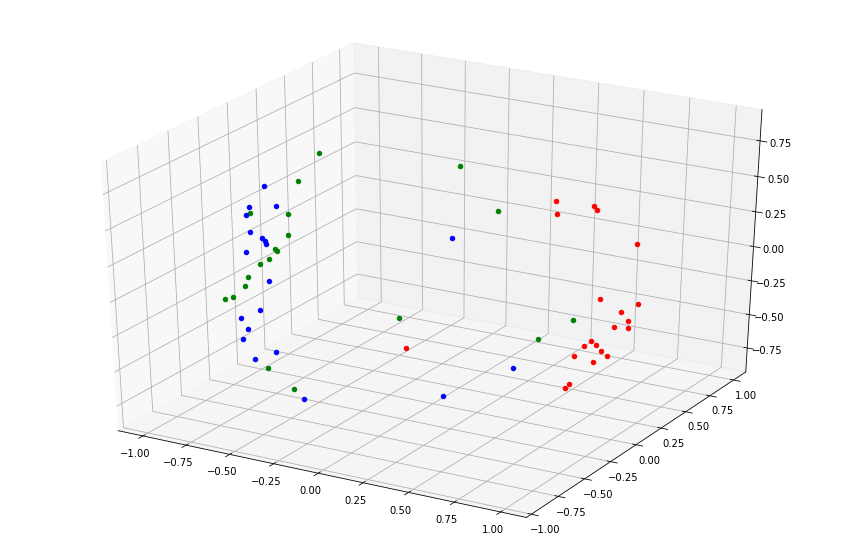

In [10]:
def norm_vectors(A):
    An = A.copy()
    #TODO write here a code that will norm each vector, 
    # i.e. will divide each row of A by its norm ||A[i]||
    An = An / np.linalg.norm(An, ord=2, axis=1, keepdims=True)
    return An
    
An = norm_vectors(Ak)

print("2 first dimensions")
show_points_2d(An.T[0], An.T[1], "1 principal component", "2 principal component")
show_points_3d(An.T[0], An.T[1], An.T[2])

## Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. Please, write the code that will return $k$ closest food items to the provided query vector.

In [12]:
def find_k_closest(query, dataset, k=5):    
    #TODO write here the code that will find 5 closest rows in dataset in terms of cosine similarity
    #HINT: as vectors in dataset are already normed, cosine similarity is just dot product.    
    similarities = [(i, sample, np.dot(query, sample)) for i, sample in enumerate(dataset)]
    similarities.sort(key = lambda x: x[-1], reverse=True)
    return similarities[:k]


recommend_to = 0
r = find_k_closest(An[recommend_to,:], An)


print("For:", names[recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", names[k], "sim=", p)

For: Asparagus, 5 spears (93 g/3.3 oz)
	 Peach, 1 medium (147 g/5.3 oz) sim= 0.9900306633803703
	 Green (Snap) Beans, 3/4 cup cut (83 g/3.0 oz) sim= 0.9830960808594849
	 Plums, 2 medium (151 g/5.4 oz) sim= 0.9740244451806315
	 Onion, 1 medium (148 g/5.3 oz) sim= 0.9705752498785495


## Try this on text data

Use andy documents collection you want. It might be a Reuters dataset. 
You need to normalize this dataset and calculate the next index:

    - `index`, `term:[collection_frequency, (doc_id_1, doc_freq_1), (doc_id_2, doc_freq_2), ...]`
    - `doc_lengths`, `doc_id:doc_length` 

limit the number of words and documents using the sizes as a paramether of the function which calculate index.

In [74]:
# TODO calculate index and document lengthes for reuters collection
# dataset: https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/elonmusk_tweets.csv
import re
import pandas as pd
from tqdm import tqdm
from collections import Counter


class CountDict(dict):
    """
    Class that is used as counter, inherited from dict. 
    """
    def __getitem__(self, item):
        """
        Gets item without exceptions
        :param item:  key you want to get
        :return: value, associated with `item` (if item in the `keys`), 0 otherwise
        """
        if item not in self:
            return 0
        return super().__getitem__(item)


def normalize(text, allow_asterix=False):
    text = text.lower()
    text = re.sub('\'', '', text)                          # remove apostrophes
    text = re.sub('[!@#$.\*\\-+—,\(\)/:“”]', ' ', text)     # replace all punctuation signs with spaces
    #text = re.sub('[0-9]', ' ', text)                      # replace all digits with spaces
    result = " ".join([x.lower() for x in text.split()])   # lower all letters and delete all doubled spaces
    return result


def make_index(dataset, ids=None):
    index = dict()
    doc_lenghts = dict()
    for doc_id, doc in tqdm(enumerate(dataset), desc='Constructing index'):
        doc = normalize(doc).split()
        if ids is not None:
            doc_id = ids[doc_id]
    
        doc_lenghts[doc_id] = len(doc)
        
        for term in doc:
            if term not in index:
                index[term] = CountDict()
            index[term][doc_id] += 1
            index[term]['collection'] += 1

    return index, doc_lenghts


csv = 'people_wiki.csv'
df = pd.read_csv(csv).head(1000)
print(df.shape)
print(df.columns)
doc_ids = list(range(len(df)))
index, doc_lenghts = make_index(df['text'], doc_ids)
index['march']

Constructing index: 255it [00:00, 2538.43it/s]

(1000, 3)
Index(['URI', 'name', 'text'], dtype='object')


Constructing index: 1000it [00:00, 2307.35it/s]


{5: 1,
 'collection': 182,
 7: 1,
 11: 1,
 19: 1,
 23: 1,
 26: 1,
 28: 1,
 29: 1,
 42: 1,
 52: 2,
 54: 1,
 62: 1,
 63: 1,
 70: 1,
 76: 1,
 79: 1,
 103: 2,
 104: 1,
 107: 1,
 110: 1,
 112: 1,
 123: 1,
 124: 1,
 126: 1,
 134: 1,
 136: 1,
 137: 1,
 146: 1,
 158: 1,
 162: 1,
 173: 1,
 179: 1,
 180: 1,
 187: 1,
 188: 1,
 194: 1,
 198: 2,
 200: 1,
 208: 1,
 213: 1,
 233: 1,
 241: 1,
 246: 1,
 248: 1,
 259: 2,
 271: 1,
 274: 1,
 276: 1,
 298: 1,
 302: 1,
 303: 1,
 311: 2,
 317: 1,
 320: 1,
 329: 1,
 332: 1,
 344: 3,
 346: 2,
 352: 1,
 354: 3,
 363: 1,
 374: 1,
 383: 1,
 385: 2,
 387: 1,
 414: 2,
 419: 1,
 424: 1,
 428: 2,
 434: 1,
 441: 1,
 451: 1,
 457: 2,
 473: 2,
 475: 1,
 476: 1,
 501: 1,
 502: 1,
 509: 1,
 514: 1,
 516: 1,
 520: 1,
 526: 1,
 533: 2,
 542: 1,
 545: 1,
 546: 1,
 551: 1,
 565: 1,
 578: 1,
 579: 1,
 584: 1,
 592: 1,
 596: 1,
 598: 1,
 605: 2,
 620: 1,
 626: 1,
 629: 1,
 637: 1,
 639: 1,
 641: 1,
 649: 1,
 652: 1,
 659: 2,
 669: 1,
 674: 2,
 677: 1,
 686: 1,
 693: 1,
 710: 1,


## 2. Term-Document Matrix

Now, it's time to check how well does this work for text data. 
1. Take the inverted index you built; 
2. Build Term-Document Matrix, where each row is a document, and each column is a term, and at the intersection there's a TF-IDF value;
3. Apply the same procedure as above (PCA transform + normalization). Check the amount of variance explained;
4. For a given document show a closest ones using cosine similarity;
5. Similarly, show closest documents for a given query.

Display cosine similarity for all search results along with urls.

In [48]:
#TODO provide your solution for text data
import pandas as pd
from math import log2
from tqdm import tqdm

def calc_tf(term, doc, index, doc_lenghts):
    return index[term][doc] / doc_lenghts[doc]

def calc_idf(term, doc, index, doc_lenghts):
    return log2( len(doc_lenghts) / len(index[term]) )

def calc_tf_idf(term, doc, index, doc_lenghts):
    return calc_tf(term, doc, index, doc_lenghts) * calc_idf(term, doc, index, doc_lenghts)


matrix = pd.DataFrame(index=doc_ids, columns=index.keys(), dtype=float)
for doc_id, row in tqdm(matrix.iterrows(), desc='Calculating TF-IDF matrix'):
    for term in row.keys():
        row[term] = calc_tf_idf(term, doc_id, index, doc_lenghts)

matrix.isnull().values.any()


Calculating TF-IDF matrix: 1000it [04:01,  3.77it/s]


False

In [33]:
A = np.array(matrix.values.astype(float))

pca = PCA(n_components=0.75)
pca.fit(A)
Ak = pca.transform(matrix)
Ak = norm_vectors(Ak)

print(matrix.shape, Ak.shape)
print('Variance ratio list size:', len(pca.explained_variance_ratio_))
print('Variance ratio:', pca.explained_variance_ratio_[:2])

(1000, 34257) (1000, 569)
Variance ratio list size: 569
Variance ratio: [0.00696027 0.0059959 ]


In [49]:
"""!pip3 install plotly
!pip3 install plotly-express

import plotly.express as px


first_two = Ak.T[0:2].T
first_two = norm_vectors(first_two)

d = pd.DataFrame(first_two, columns=['x', 'y'])
d['hover'] = df['text']
fig = px.scatter(d, x='x', y='y', hover_data=['hover'])
fig.show()"""

"!pip3 install plotly\n!pip3 install plotly-express\n\nimport plotly.express as px\n\n\nfirst_two = Ak.T[0:2].T\nfirst_two = norm_vectors(first_two)\n\nd = pd.DataFrame(first_two, columns=['x', 'y'])\nd['hover'] = df['text']\nfig = px.scatter(d, x='x', y='y', hover_data=['hover'])\nfig.show()"

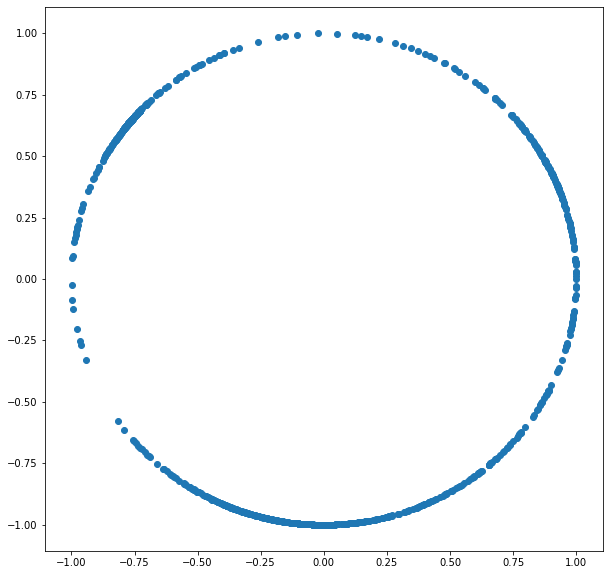

In [32]:
import matplotlib.pyplot as plt

first_two = Ak.T[0:2].T
first_two = norm_vectors(first_two)

d = pd.DataFrame(first_two, columns=['x', 'y'])
plt.figure(figsize=(10, 10))
plt.scatter(x=first_two.T[0], y=first_two.T[1])

## Similarity with document

In [41]:
recommend_to = 5
r = find_k_closest(Ak[recommend_to, :], Ak)

print("For:", df['name'][recommend_to], df['URI'][recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", df['name'][k], df['URI'][k], "sim=", p)

For: Sam Henderson <http://dbpedia.org/resource/Sam_Henderson>
	 Professor Lyrical (rapper) <http://dbpedia.org/resource/Professor_Lyrical_(rapper)> sim= 0.859964178964911
	 Yohannes Yual <http://dbpedia.org/resource/Yohannes_Yual> sim= 0.832792810076352
	 Vanessa Ament <http://dbpedia.org/resource/Vanessa_Ament> sim= 0.7202957666225073
	 Timothy Grucza <http://dbpedia.org/resource/Timothy_Grucza> sim= 0.7016224158917974


## Similarity with query

In [81]:
from collections import Counter

def proceed_query(query):
    global index, doc_lenghts
    query = query.lower()
    query = query.split()
    
    cnt = dict(Counter(query))
    matrix = pd.DataFrame(index=[-1], columns=index.keys(), dtype=float)
    doc_id = -1
    for col in matrix.columns:
        matrix[col].values[:] = 0
    for term in query:
        tf = cnt[term] / len(query)
        idf = len(doc_lenghts) / len(index[term])
        matrix[term][doc_id] = tf * idf
        
    Ak = pca.transform(matrix)
    Ak = norm_vectors(Ak)
    return Ak[-1, :]
    

r = find_k_closest(proceed_query('american engineer'), Ak)
print("For:", df['name'][recommend_to], df['URI'][recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", df['name'][k], df['URI'][k], "sim=", p)

For: Sam Henderson <http://dbpedia.org/resource/Sam_Henderson>
	 Filippo Gaetani <http://dbpedia.org/resource/Filippo_Gaetani> sim= 0.4891025989792144
	 Anthony Gueterbock, 18th Baron Berkeley <http://dbpedia.org/resource/Anthony_Gueterbock,_18th_Baron_Berkeley> sim= 0.38768932245155685
	 Daniel Janssen <http://dbpedia.org/resource/Daniel_Janssen> sim= 0.3782919997952032
	 Andrew S. Haydon <http://dbpedia.org/resource/Andrew_S._Haydon> sim= 0.3346283827050939
	 Ryan Callus <http://dbpedia.org/resource/Ryan_Callus> sim= 0.30595035045055385
